In [1]:
from data import dataset, PlantOrgansDataset
from preprocessing import preprocess_image_and_mask
import torchvision.transforms.v2 as T
import torch
import numpy as np
from alexnet import MyTransform, SlidingWindow, get_extractor, get_feature, get_model
from train import device, pixel_validate, patch_loss, patch_validate, evaluate, fit
import torch.utils.data as data_utils
from kmeans import KMeans, KNN
from evaluate import calculate_metrics
from torch.utils.data import DataLoader
from alexnet_knn import perform_segmentation, save_features, segmentation_image, retrieve_features, read_features, load_and_merge_knn_features
import umap
from sklearn.manifold import trustworthiness
import pickle
import os
import lz4

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Using cache found in C:\Users\pc/.cache\torch\hub\pytorch_vision_v0.10.0
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\pc/.cache\torch\hub\pytorch_vision_v0.10.0


In [2]:
commonTransform = T.Compose([
        T.Resize(size=(2048, 2048)),
        T.ToImage()
        
        # T.RandomHorizontalFlip(p=0.5),
        # T.RandomVerticalFlip(p=0.5),
        # T.RandomRotation(degrees=45)
    ])
imagesTransform = T.Compose([
    T.ToDtype(torch.float32, scale=False),
    # T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    MyTransform(64),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
masksTransform = T.Compose([
    T.ToDtype(torch.int8, scale=False),
    # T.Normalize(mean=[0.0014], std=[0.0031]),
    MyTransform(64),
    # T.Resize((224, 224))
])

In [3]:
train_validation_data = dataset['train'].train_test_split(test_size=0.2, seed=42)
train_dataset = PlantOrgansDataset(train_validation_data['train'], commonTransform, imagesTransform, masksTransform)
validation_dataset = PlantOrgansDataset(train_validation_data['test'], commonTransform, imagesTransform, masksTransform)
test_dataset = PlantOrgansDataset(dataset['validation'], commonTransform, imagesTransform, masksTransform)


In [4]:
cross_entropy_weights = torch.tensor([
        4.8033e-04,
        6.4129e-03,
        3.9272e-03,
        9.7140e-01,
        1.7778e-02], device=device)

In [5]:
print("train_dataset: ", len(train_dataset))
print("validation_dataset: ", len(validation_dataset))
print("test_dataset: ", len(test_dataset))

train_dataset:  4596
validation_dataset:  1149
test_dataset:  1437


In [6]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            batch_cuda = []
            for X, y in batch:
                batch_cuda.append(self.func(X, y))
            yield batch_cuda

In [7]:
def to_device(X: torch.Tensor, y: torch.Tensor):
    return X.to(device, dtype=torch.float32), y.to(device, dtype=torch.int8)

In [8]:
batch_size = 1024

In [9]:
def custom_collate_fn(batch):
    batchs_amount = len(batch)
    current_images = []
    current_masks = []
    current_length = 0
    i = 0
    while i < batchs_amount or current_length >= batch_size:
        if current_length == batch_size:
            if len(current_images) == 1:
                result_images = current_images[0]
                result_masks = current_masks[0]
            else:
                result_images = torch.concatenate(current_images)
                result_masks = torch.concatenate(current_masks)
            current_images = []
            current_masks = []
            current_length = 0
            yield result_images, result_masks
        elif current_length > batch_size:
            concatenated_images = torch.concatenate(current_images)
            concatenated_masks = torch.concatenate(current_masks)
            images_split = torch.split(concatenated_images, batch_size, dim=0)
            masks_split = torch.split(concatenated_masks, batch_size, dim=0)
            current_images = [images_split[len(images_split) - 1]]
            current_masks = [masks_split[len(masks_split) - 1]]
            current_length = len(current_images[0])
            for j in range(len(images_split) - 1):
                yield images_split[j], masks_split[j]
        else:  
            images, masks = batch[i]
            i += 1
            current_length += len(images)
            current_images.append(images)
            current_masks.append(masks)
    if current_length > 0:
        concatenated_images = torch.concatenate(current_images)
        concatenated_masks = torch.concatenate(current_masks)
        yield concatenated_images, concatenated_masks



In [10]:

train_loader = WrappedDataLoader(
    DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn, 
               pin_memory=True, pin_memory_device=[device]), to_device)
valid_loader = WrappedDataLoader(
    DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn,
               pin_memory=False, pin_memory_device=[device]), to_device)
test_loader = WrappedDataLoader(
    DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn,
               pin_memory=False, pin_memory_device=[device]), to_device)

In [11]:
src_path = "C:\\Users\\pc\\Documents\\repos\\mp-2\\nn\\nn-lab2\\"

constants = {
    "criterion": torch.nn.CrossEntropyLoss(),
    "lr": 0.0001,
    "n_epochs": 40,
    "saving_model_path": src_path + "models\\raytune"
}
config = {
    # "batch_size": tune.grid_search([64*64]),
    # "patch_size": tune.grid_search([32])
}

In [12]:
image_to_tensor = T.Compose([
    # T.ToImage(),
    T.ToDtype(dtype=torch.float32, scale=True),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize(size=(2048, 2048)),
])
mask_to_tensor = T.Compose([
    T.ToImage(),
    T.ToDtype(dtype=torch.float32, scale=False)
])
mask_of_uniform_size = T.Compose([
    T.Resize((2048, 2048), interpolation=T.InterpolationMode.NEAREST_EXACT),
    mask_to_tensor,
])

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
# image = train_validation_data['train'][1]['image']
# X = image_to_tensor(image).unsqueeze(0).to(device)
# y = mask_of_uniform_size(train_validation_data['train'][1]['label']).to(device)

In [14]:
# T.Resize((224, 224))(train_validation_data['train'][1]['image'])
# T.Resize((224, 224))(mask_to_image(train_validation_data['train'][1]['label']))

from torchvision.models.feature_extraction import get_graph_node_names
# get_graph_node_names(model)
torch.cuda.empty_cache()


# import torch
# import gc
# objects = []
# for obj in gc.get_objects():
#     try:
#         if (torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data))) and obj.is_cuda:
#             objects.append((type(obj), obj.size(), obj.numel()))
#     except:
#         pass

# sorted_by_size = sorted(objects, key=lambda tup: tup[2], reverse=True)
# sorted_by_size

In [15]:
# predicted_classes = perform_segmentation(X, y.unsqueeze(0))
# segmentation_image(predicted_classes)

In [16]:
# del X, y
torch.cuda.empty_cache()

In [17]:
# segmentation_image(mask_to_tensor(train_validation_data['train'][1]['label'])[0])

In [18]:
# image = train_validation_data['train'][1]['image']
# X = image_to_tensor(image).unsqueeze(0).to(device)

In [19]:
# import tqdm
# for i in tqdm.tqdm(range(100)):
#     image = train_validation_data['train'][i]['image']
#     features = retrieve_features(image_to_tensor(image).unsqueeze(0).to(device))
#     save_features(i, features)

In [20]:

def read_features(index, src_path, layer_name="classifier.0", sliding_window_size=32, 
                         sliding_window_step=11):
    file_name = os.path.join(src_path, "features", 
                            "train_{layer_name}_{window_size}_{window_step}_{i}.lz4"
                              .format(layer_name=layer_name, window_size=sliding_window_size, window_step=sliding_window_step, i=index)
                            )
    with lz4.frame.open(file_name, mode="rb") as f:
      features_shape = pickle.load(f)
      features = pickle.load(f)
      return features

In [21]:
def get_ground_truth_for_indices(indices, dataset_tag='train'):
    if dataset_tag == 'train':
        dataset_ = train_validation_data['train']
    elif dataset_tag == 'test':
        dataset_ = dataset['validation']
    else:
        dataset_ = train_validation_data['test']
    ground_truths = []
    for i in indices:
        ground_truth = mask_of_uniform_size(dataset_[i]['label']).to("cpu")
        mask_patches = SlidingWindow(32, 11)(ground_truth.unsqueeze(0))
        mask_patches_ = mask_patches.view(mask_patches.size(0), mask_patches.size(1), -1)
        ground_truths.append(torch.mode(mask_patches_, dim=2).values.to(dtype=torch.int8).view(-1))
        del ground_truth, mask_patches, mask_patches_
    merged_ground_truths = torch.cat(ground_truths, dim=0).to(device)
    del ground_truths
    return merged_ground_truths

In [22]:
with open(os.path.join("f:", "d","umap_model_5.lz4"), 'rb') as f:
    reducer = pickle.load(f)

In [23]:
# reducer = umap.UMAP(n_neighbors=30, n_components=64, low_memory=True)
# features_to_train_reducer = load_and_merge_knn_features("cpu", src_path, indices=range(5))

In [24]:
# ground_truths_to_train_reducer = get_ground_truth_for_indices(range(5), dataset_tag='train')

In [25]:
# ground_truths_to_train_reducer = ground_truths_to_train_reducer.to("cpu")

In [26]:
# reducer.fit(features_to_train_reducer, ground_truths_to_train_reducer)

In [27]:
# file_name = os.path.join("f:\d", "umap_model_5.lz4")
# with open(file_name, mode="wb") as f:
#       pickle.dump(reducer, f, protocol=5)

In [28]:
def load_transformed_features(src_path, file_name):
    with lz4.frame.open(os.path.join(src_path, "features", file_name), mode="rb") as f:
        _ = pickle.load(f)
        loaded_f = pickle.load(f)
    return loaded_f

In [29]:

torch.cuda.empty_cache()


In [30]:
# train_features = load_transformed_features(src_path, "10_train_reduced.lz4")
# validation_features = load_transformed_features(src_path, "0_validation_reduced.lz4")

In [31]:
# features_transformed = reducer.transform(features)
# features_transformed_ = torch.tensor(features_transformed)

In [ ]:
features = load_and_merge_knn_features("cpu", src_path, indices=range(, 30), reducer=reducer, name="train")

c:\ProgramData\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
c:\ProgramData\anaconda3\Lib\

In [35]:
file_name = os.path.join(src_path, "features", "30_train_reduced_5.lz4")
with lz4.frame.open(file_name, mode="wb") as f:
      pickle.dump(features.shape , f) 
      pickle.dump(features, f)

In [28]:
ground_truths = get_ground_truth_for_indices(range(10), dataset_tag='validation')
torch.cuda.empty_cache()

In [29]:
ground_truths

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)

In [30]:
print(train_features.shape, " ", ground_truths.shape)

torch.Size([349690, 64])   torch.Size([349690])


In [31]:
# test_features = load_and_merge_knn_features()


In [33]:
knn = KNN(train_features, ground_truths.to(device), 5, save_memory=True)

In [34]:
test_transformed_square = validation_features.view(validation_features.size(0), validation_features.size(1), -1)

In [35]:
# del features
torch.cuda.empty_cache()

In [36]:
predicted_mask = torch.zeros((187, 187))
test_transformed_square = validation_features.view(187, 187, -1)
for i in range(0, 187, 39):
    i_upper_limit = min(i+39, 187)
    predicted_classes = knn.predict(test_transformed_square[i : i_upper_limit].view(-1, 64).to(device, dtype=torch.int64))
    torch.cuda.empty_cache()
    predicted_mask[i : i_upper_limit] = predicted_classes.view(-1, 187).to("cpu")
    print(i)
        
    

0
39
78
117
156


In [37]:
torch.cuda.empty_cache()

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


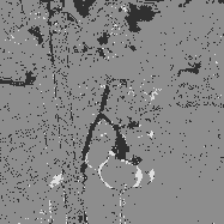

In [38]:
segmentation_image(mask_to_tensor(predicted_mask)[0])